In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
# Load the dataset
RNDSTATE = 42

df = pd.read_csv("C:/.../python_workspace/ml/inputs/heart.csv", delimiter=",")

labels = df["output"]
data = df[[c for c in df.columns if c != "output"]]

In [3]:
len(data.columns)

13

In [4]:
# Split the dataset in training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=RNDSTATE)

In [5]:
# Only two features are not scaled: Time and Amount
# Substract the mean and scale to unit variance
scaler_train = StandardScaler()
scaler_test = StandardScaler()

X_train = scaler_train.fit_transform(X_train)
X_train = tf.cast(X_train, tf.float32)

X_test = scaler_test.fit_transform(X_test)
X_test = tf.cast(X_test, tf.float32)

In [6]:
###################################
# PART I: Feature Space Reduction #
###################################

# Model
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(13, activation="relu"),
          layers.Dense(2, activation="relu"),
        ])

        self.decoder = tf.keras.Sequential([
          layers.Dense(13, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AutoEncoder()

In [7]:
autoencoder.compile(optimizer='adam', loss='mae')

# Model weights are saved at the end of every epoch, if it's the best seen so far
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

EPOCHS = 50
history = autoencoder.fit(
    X_train,
    X_train, 
    epochs=EPOCHS, 
    batch_size=4,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

# We load the best weight into the model
autoencoder.load_weights(checkpoint_filepath)

Epoch 1/50
61/61 [==============================] - 1s 7ms/step - loss: 0.9458 - val_loss: 0.9420
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.9408 - val_loss: 0.9387
Epoch 3/50
61/61 [==============================] - 0s 4ms/step - loss: 0.9360 - val_loss: 0.9367
Epoch 4/50
61/61 [==============================] - 0s 3ms/step - loss: 0.9303 - val_loss: 0.9348
Epoch 5/50
61/61 [==============================] - 0s 3ms/step - loss: 0.9231 - val_loss: 0.9310
Epoch 6/50
61/61 [==============================] - 0s 4ms/step - loss: 0.9130 - val_loss: 0.9230
Epoch 7/50
61/61 [==============================] - 0s 4ms/step - loss: 0.8972 - val_loss: 0.9072
Epoch 8/50
61/61 [==============================] - 0s 4ms/step - loss: 0.8749 - val_loss: 0.8867
Epoch 9/50
61/61 [==============================] - 0s 3ms/step - loss: 0.8537 - val_loss: 0.8702
Epoch 10/50
61/61 [==============================] - 0s 4ms/step - loss: 0.8379 - val_loss: 0.8573
Epoch 11/50
61/61 [

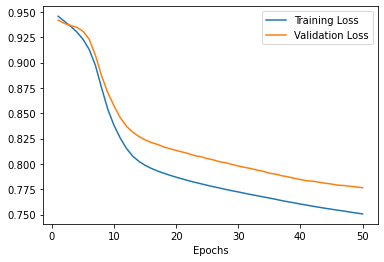

In [8]:
# Ploting the training/validation loss scores
xaxis = list(range(1, EPOCHS + 1))

plt.plot(xaxis, history.history["loss"], label="Training Loss")
plt.plot(xaxis, history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.legend()

In [9]:
######################################
# PART II: Classification comparison #
######################################

# We compress our feature space thanks to our trained AE
X_train_encoded = autoencoder.encoder(X_train).numpy()
X_test_encoded = autoencoder.encoder(X_test).numpy()

# RF parameters
PARAM = {
    'max_depth': 3,
    'n_estimators': 10,
    'random_state': RNDSTATE
}
rf = RandomForestClassifier(**PARAM)

# Training and test on the compressed datasets
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

In [10]:
# Training and test on the un-compressed datasets
rf2 = RandomForestClassifier(**PARAM)
rf2.fit(X_train.numpy(), y_train)

# RF prediction
y_pred2 = rf2.predict(X_test)

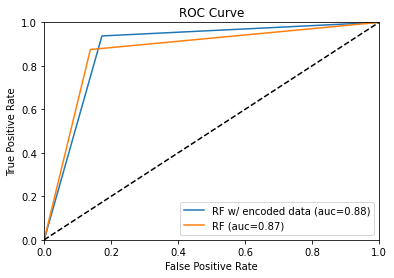

In [12]:
# Ploting the receiver operating characteristic curve for both models
fpr, tpr, _ = roc_curve(y_test, y_pred)
fpr2, tpr2, _2 = roc_curve(y_test, y_pred2)

plt.plot(fpr, tpr, label='RF w/ encoded data (auc=%0.2f)' % auc(fpr, tpr))
plt.plot(fpr2, tpr2, label='RF (auc=%0.2f)' % auc(fpr2, tpr2))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")

plt.savefig('roc_curves_comparison.png', facecolor='lightgrey', bbox_inches='tight')

plt.show()